In [63]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import statsmodels.api as sm
from datetime import datetime
%matplotlib inline

In [2]:
df = pd.read_csv('NYPD_7_Major_Felony_Incident_Map.csv')
df.head(2)

,OBJECTID,Identifier,Occurrence Date,Day of Week,Occurrence Month,Occurrence Day,Occurrence Year,Occurrence Hour,CompStat Month,CompStat Day,CompStat Year,Offense,Offense Classification,Sector,Precinct,Borough,Jurisdiction,XCoordinate,YCoordinate,Location 1
0,1.0,f070032d,09/06/1940 07:30:00 PM,Friday,Sep,6.0,1940.0,19.0,9.0,7.0,2010.0,BURGLARY,FELONY,D,66.0,BROOKLYN,N.Y. POLICE DEPT,987478.0,166141.0,"(40.6227027620001, -73.9883732929999)"
1,2.0,c6245d4d,12/14/1968 12:20:00 AM,Saturday,Dec,14.0,1968.0,0.0,12.0,14.0,2008.0,GRAND LARCENY,FELONY,G,28.0,MANHATTAN,N.Y. POLICE DEPT,996470.0,232106.0,"(40.8037530600001, -73.955861904)"


In [13]:
df_selected = df[(df["Occurrence Year"] <= 2015) &
              (df["Occurrence Year"] > 2005) &
              (df["Borough"] == "BROOKLYN") &
              (df["Offense"] == "ROBBERY")]
df_selected = df_selected[["CompStat Year", "CompStat Month"]]
df_selected["n"] = 1
df_grouped = df_selected.groupby(["CompStat Year", "CompStat Month"]).aggregate(np.sum)

In [14]:
df_grouped.head(10)

n
CompStat Year CompStat Month     
2006.0        1.0             737
              2.0             503
              3.0             604
              4.0             588
              5.0             724
              6.0             712
              7.0             726
              8.0             709
              9.0             674
              10.0            798

In [16]:
def ym_to_datetime(x):
    year, month = x
    return datetime(int(year), int(month), 1)

In [18]:
indvalues = df_grouped.index.get_values()
vect_ym = np.vectorize(ym_to_datetime)
date_array = vect_ym(indvalues)
date_col = pd.Series(date_array, name="date")
n_col = df_grouped["n"]
n_col = pd.Series(n_col.values, name="n")
ts = pd.DataFrame(date_col)
ts["n"] = n_col
ts = ts.set_index("date")
ts.head()

,n
date,
2006-01-01,737
2006-02-01,503
2006-03-01,604
2006-04-01,588
2006-05-01,724


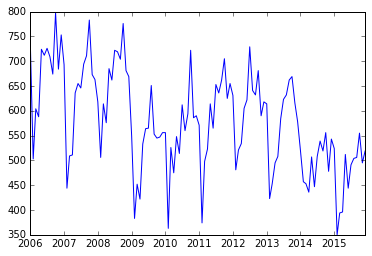

In [19]:
plt.plot(ts)

* Временной ряд - нестационарный
* Тренд - отрицательный
* Колебания - пик ограблений в середине/конце года

Исследование автокорреляции:

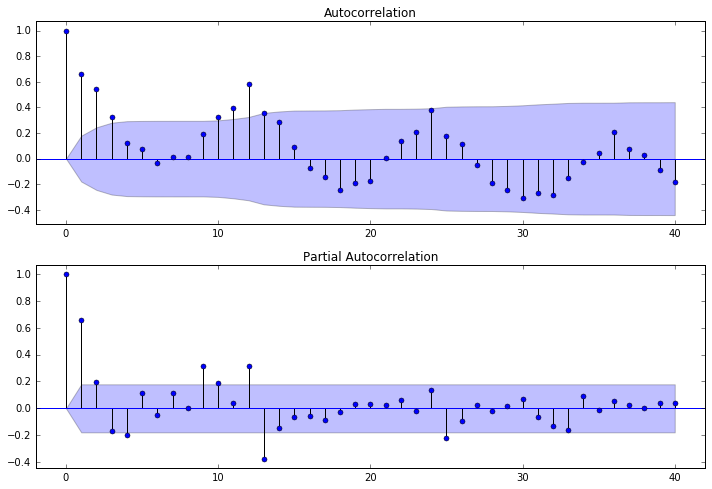

In [20]:
from statsmodels.graphics.api import qqplot

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags=40, ax=ax2)

Отчётливо видны тренд и сезонные колебания.
Частота - 12 лагов, что соответствует 1 году.

Для избавления от гетероскедастичности прологарифмируем:

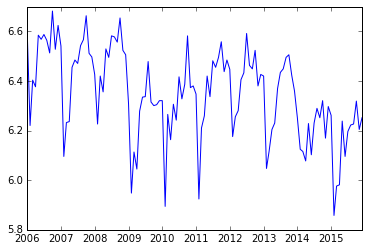

In [21]:
ts_log = np.log(ts)
plt.plot(ts_log)

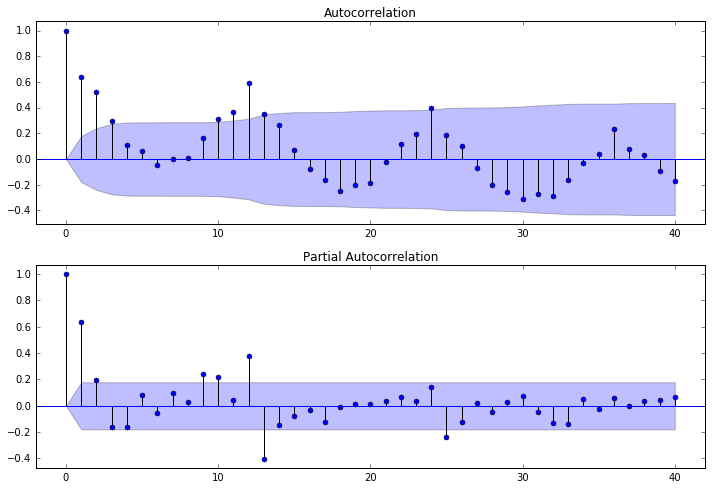

In [22]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_log, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_log, lags=40, ax=ax2)

Тест Дики-Фуллера для определения стационарности:

In [23]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries["n"], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    #for key,value in dftest[4].items():
    #    dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).std()


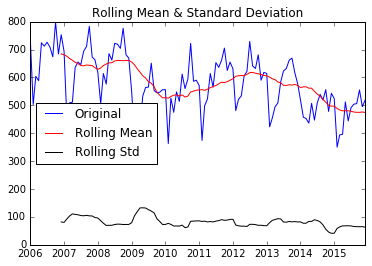

Results of Dickey-Fuller Test:
Test Statistic                  -1.284211
p-value                          0.636364
#Lags Used                      12.000000
Number of Observations Used    107.000000
dtype: float64


In [24]:
test_stationarity(ts)

D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).std()


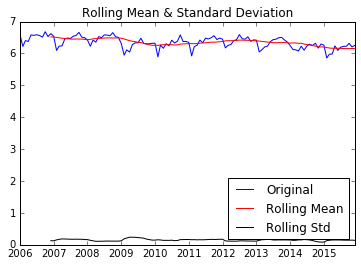

Results of Dickey-Fuller Test:
Test Statistic                  -1.117076
p-value                          0.708214
#Lags Used                      12.000000
Number of Observations Used    107.000000
dtype: float64


In [25]:
test_stationarity(ts_log)

Поскольку p-value намного отличается от нуля, ряд явно нестационарный.

Возьмём разности ряда, чтобы устранить тренд.

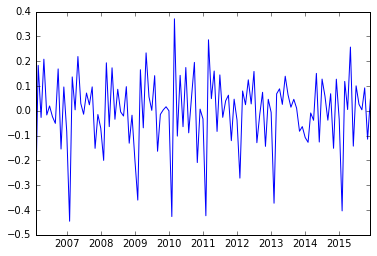

In [26]:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
plt.plot(ts_log_diff)

D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).std()


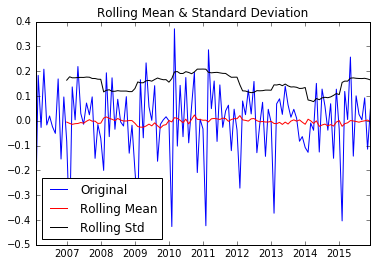

Results of Dickey-Fuller Test:
Test Statistic                  -4.440246
p-value                          0.000252
#Lags Used                      11.000000
Number of Observations Used    107.000000
dtype: float64


In [27]:
test_stationarity(ts_log_diff)

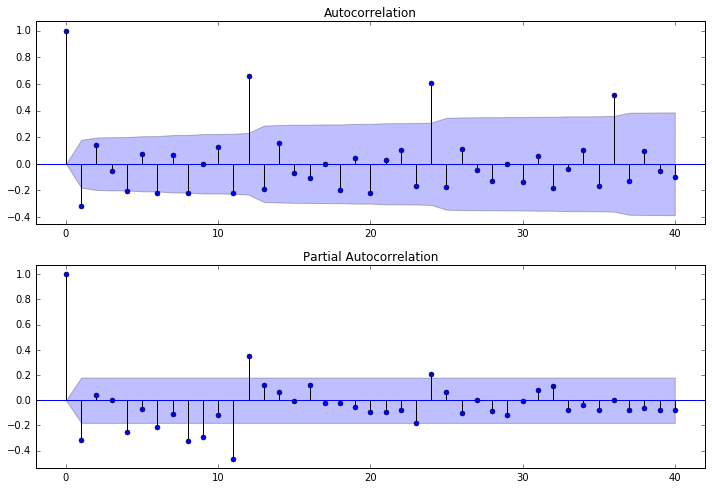

In [28]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_log_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_log_diff, lags=40, ax=ax2)

Из графика автокорреляции видно, что тренд больше не влияет и остались только максимумы от сезонной составляющей (каждые 12 лагов).

Устраним и её:

D:\Anaconda2\lib\site-packages\statsmodels\tsa\filters\filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


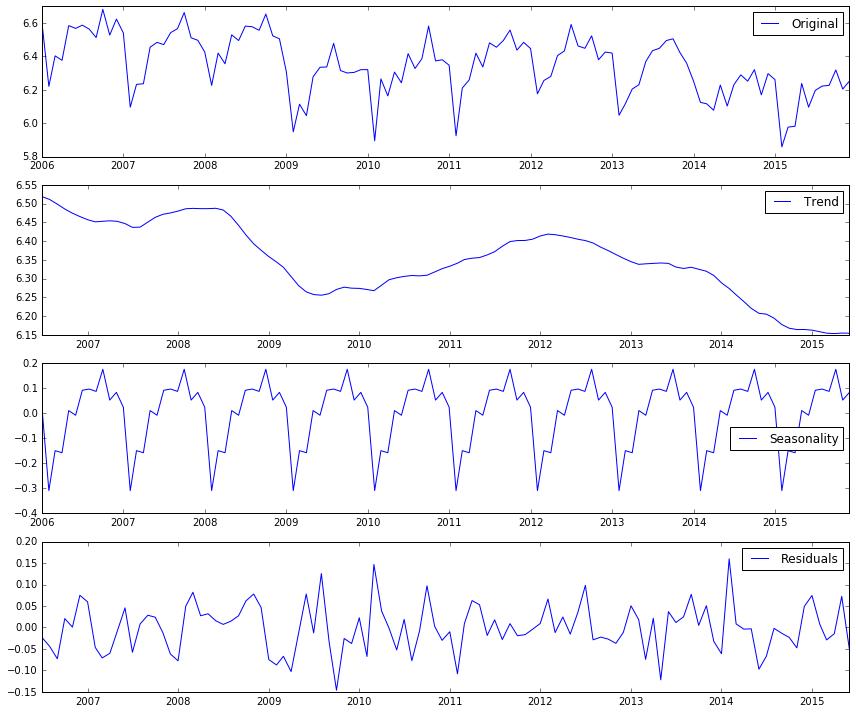

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts_log = ts_log.dropna()
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,10))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).std()


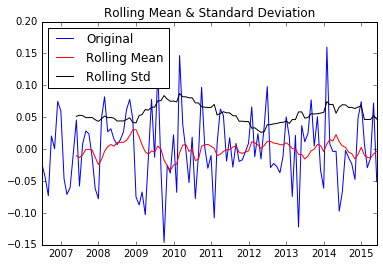

Results of Dickey-Fuller Test:
Test Statistic                -7.590045e+00
p-value                        2.545628e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.040000e+02
dtype: float64


In [38]:
test_stationarity(residual.dropna())

**Остатки стационарны.**

Подбор параметров ARIMA:

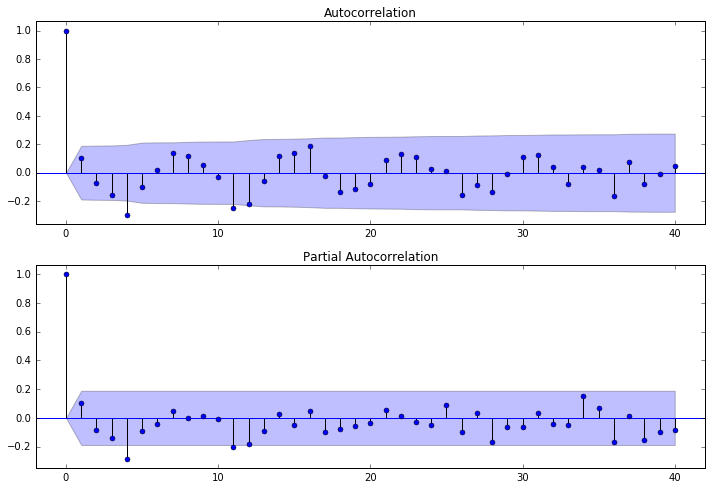

In [42]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residual.dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residual.dropna(), lags=40, ax=ax2)

Возьмём параметры (1, 0, 1) для модели.

In [44]:
model = sm.tsa.ARIMA(residual.dropna(), order=(1,0,1))
fmodel = model.fit(method="mle")
fmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      n   No. Observations:                  108
Model:                     ARMA(1, 1)   Log Likelihood                 160.155
Method:                           mle   S.D. of innovations              0.055
Date:                Mon, 27 Jun 2016   AIC                           -312.311
Time:                        07:02:02   BIC                           -301.582
Sample:                    07-01-2006   HQIC                          -307.961
                         - 06-01-2015                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0009      0.006     -0.160      0.873        -0.012     0.010
ar.L1.n       -0.5825      0.361     -1.613      0.110        -1.290     0.125
ma.L1.n        0.6929      0.319      2.173      0.032         0.068     1.318
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.7166           +0.0000j            1.7166            0.5000
MA.1           -1.4432           +0.0000j            1.4432            0.5000
-----------------------------------------------------------------------------
"""

D:\Anaconda2\lib\site-packages\statsmodels\base\data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


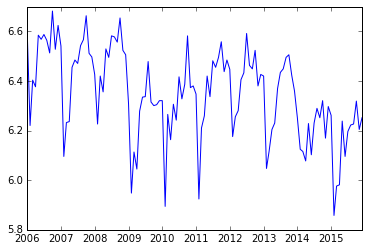

In [45]:
insample_predict=fmodel.predict()
plt.plot(ts_log)

In [46]:
model = sm.tsa.ARIMA(ts_log, order=(12,1,0))
fmodel = model.fit(method="mle")
fmodel.summary()

D:\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.n   No. Observations:                  119
Model:                ARIMA(12, 1, 0)   Log Likelihood                 114.488
Method:                           mle   S.D. of innovations              0.089
Date:                Mon, 27 Jun 2016   AIC                           -200.976
Time:                        07:02:29   BIC                           -162.068
Sample:                    02-01-2006   HQIC                          -185.177
                         - 12-01-2015                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0033      0.002     -1.583      0.116        -0.007     0.001
ar.L1.D.n     -0.3928      0.084     -4.701      0.000        -0.557    -0.229
ar.L2.D.n     -0.2841      0.087     -3.251      0.002        -0.455    -0.113
ar.L3.D.n     -0.3038      0.089     -3.408      0.001        -0.478    -0.129
ar.L4.D.n     -0.3675      0.090     -4.100      0.000        -0.543    -0.192
ar.L5.D.n     -0.3032      0.090     -3.355      0.001        -0.480    -0.126
ar.L6.D.n     -0.3204      0.087     -3.675      0.000        -0.491    -0.150
ar.L7.D.n     -0.3115      0.088     -3.520      0.001        -0.485    -0.138
ar.L8.D.n     -0.3489      0.088     -3.955      0.000        -0.522    -0.176
ar.L9.D.n     -0.3134      0.088     -3.574      0.001        -0.485    -0.142
ar.L10.D.n    -0.2393      0.089     -2.690      0.008        -0.414    -0.065
ar.L11.D.n    -0.2667      0.090     -2.960      0.004        -0.443    -0.090
ar.L12.D.n     0.4331      0.085      5.067      0.000         0.266     0.601
                                    Roots                                     
==============================================================================
                  Real           Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0294           -0.0000j            1.0294           -0.5000
AR.2            -0.8769           -0.5086j            1.0137           -0.4164
AR.3            -0.8769           +0.5086j            1.0137            0.4164
AR.4            -0.5206           -0.8916j            1.0324           -0.3341
AR.5            -0.5206           +0.8916j            1.0324            0.3341
AR.6            -0.0025           -1.0556j            1.0557           -0.2504
AR.7            -0.0025           +1.0556j            1.0557            0.2504
AR.8             0.5136           -0.8993j            1.0356           -0.1674
AR.9             0.5136           +0.8993j            1.0356            0.1674
AR.10            0.8841           -0.5069j            1.0191           -0.0829
AR.11            0.8841           +0.5069j            1.0191            0.0829
AR.12            1.6496           -0.0000j            1.6496           -0.0000
------------------------------------------------------------------------------
"""

D:\Anaconda2\lib\site-packages\statsmodels\tsa\arima_model.py:1847: FutureWarning: TimeSeries is deprecated. Please use Series
  forecast = TimeSeries(forecast, index=self.data.predict_dates)


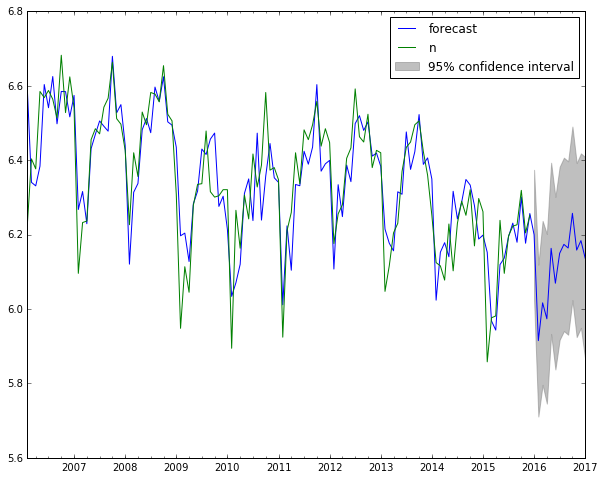

In [47]:
fig, ax1 = plt.subplots(figsize=(10,8))
fig = fmodel.plot_predict(start=1, end=132, ax=ax1,plot_insample=True,alpha=0.05,dynamic=False)

Линейная регрессия для тренда + сезонная составляющая.

In [48]:
pred_part = trend
pred_part = pred_part.dropna()

In [49]:
Y = pred_part["n"].values

In [50]:
x0 = np.array(range(len(Y)))
x1 = np.ones(len(Y))
X = np.vstack((x1, x0, x0 * x0, x0 * x0 * x0))
X = X.T

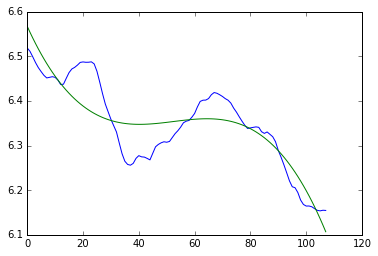

In [51]:
from sklearn.linear_model import LinearRegression

regr_model = LinearRegression()
regr_model.fit(X, Y)
pred = regr_model.predict(X)
plt.plot(Y)
plt.plot(pred)

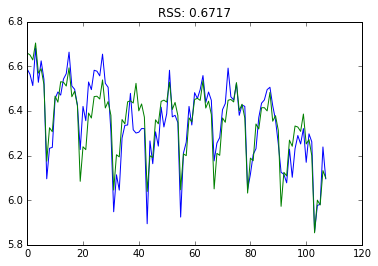

In [56]:
seasonal_adjusted = seasonal.dropna()[6:]
seasonal_adjusted = seasonal_adjusted[:-6]
seasonal_adjusted = seasonal_adjusted["n"].values
plt.plot(Y + seasonal_adjusted + residual.dropna()["n"].values)
plt.plot(pred + seasonal_adjusted)
plt.title('RSS: %.4f'% sum(((pred + seasonal_adjusted)-(Y + seasonal_adjusted + residual.dropna()["n"].values))**2))

Прогноз на год вперёд:

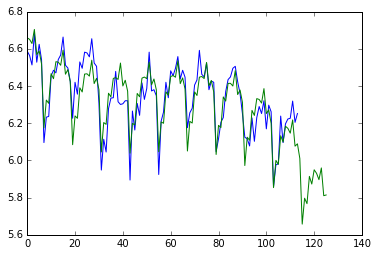

In [65]:
x02 = np.array(range(126))
X2 = np.vstack((np.ones(126), x02, np.power(x02, 2.0), np.power(x02, 3.0)))
X2 = X2.T
pred2 = regr_model.predict(X2)
seasonal2 = seasonal.dropna()["n"].values
seasonal2 = seasonal2[6:]
period = seasonal2[:12]
seasonal2 = seasonal2[:-6]
seasonal2 = np.hstack((seasonal2, period, period[:6]))
true = ts_log[6:]["n"].values
forecast = pred2 + seasonal2
plt.plot(true)
plt.plot(forecast)

Оценка доверительного интервала и дисперсии:

In [58]:
N = 108
delta = true[:N] - forecast[:N]
Sy = pow(np.sum(delta * delta) / (108 - 4), 0.5)

In [59]:
forecast_time = np.array(range(12), dtype=np.float64) + N + 6
t1 = (N + 1) / 2
f_time_2 = (forecast_time - t1) * (forecast_time - t1)
tol2 = np.array(range(N)) + 1 - t1
tol2 = np.sum(tol2 * tol2)

In [75]:
tStats = 1.9840 # 0.95 confidence interval

In [73]:
tolerance = tStats * Sy * np.power((N + 1) / N + f_time_2 / tol2, 0.5)
tolerance

array([ 0.16215637,  0.16224669,  0.16233844,  0.16243164,  0.16252627,
        0.16262234,  0.16271983,  0.16281876,  0.16291911,  0.16302089,
        0.16312409,  0.1632287 ])

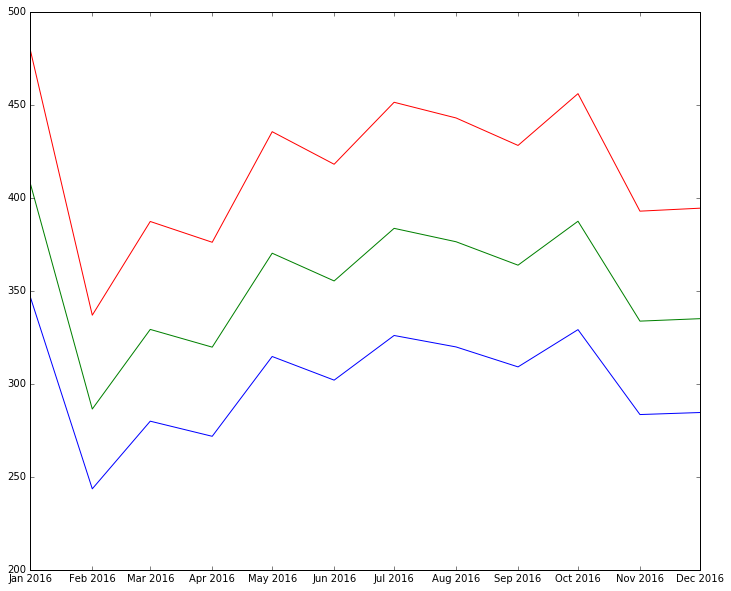

In [74]:
pure_forecast = forecast[-12:]
upper_forecast = np.exp(pure_forecast + tolerance)
lower_forecast = np.exp(pure_forecast - tolerance)
pure_forecast = np.exp(pure_forecast)

dates = [datetime(2016, i, 1) for i in xrange(1,13)]

plt.figure(figsize=(12,10))
plt.plot(pd.Series(lower_forecast, index=dates))
plt.plot(pd.Series(pure_forecast, index=dates))
plt.plot(pd.Series(upper_forecast, index=dates))